## Price Per Square Foot Prediction
In this notebook I predict the price per square foot of a house in Nashville, using an XGBoost. 
Metrics used are root mean squared error, median absolute error, mean absolute error and coefficient of determination.

Since almost all numerical features of the dataset were heavily right-skewed, I have log-transformed every numerical feature except for the target variable (PPS).

I also ran a LightGBMRegressor which got almost identical results, but ran much faster.

### Observations

Quarter and Year are pretty essential variables but I wonder if there's a better way to incorporate time.


### Next step: incorporate data from historical sales.

### Consider adding average fixtures per house in the neighborhood?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [2]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

/home/drew/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Correcting badly-entered data
df1.loc[176025, 'Sale Price'] = 37000
df1.loc[27056, 'Sale Price'] = 161000
df1.loc[191004, 'Sale Price'] = 810000
df1.loc[239278, 'Sale Price'] = 280395
df1.loc[138891, 'Sale Price'] = 200000
df1.loc[241961, 'Sale Date'] = '2019-03-04'
df1.loc[241961, 'Sale Date'] = pd.to_datetime(df1.loc[241961, 'Sale Date'])
df1.loc[241961, 'Sale Price'] = 370000
df1.loc[230115, 'Sale Price'] = 325000
df1.loc[53151, 'Sale Price'] = 310900
df1.loc[259815, 'Sale Price'] = 1513142
df1.loc[129682, 'Sale Price'] = 1300000
df1.loc[154271, 'Square Footage Improved'] = 10094
df1.drop(190142, inplace=True) #Has a massive ADU ~4 times the size of the 'main' structure. Main struct is low-grade, ADU is luxury.
df1.drop(128094, inplace=True) #Can't find out anything about this house. Improbably large sqft and acreage, low price.

In [4]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
#Testing the averaged assessment ratio idea.
df['Assessment Ratio'] = df['Assessment Land Improved'] / df['Total Appraisal Value Improved']
nbhdratio=df.groupby('Neighborhood')['Assessment Ratio'].mean().to_frame().rename(columns={'Assessment Ratio':'Nbhd Ratio'})
df=df.merge(nbhdratio, how='left', left_on = 'Neighborhood',right_index=True)
df['Month']= df['Sale Date'].dt.month
df['Quarter'] = df['Sale Date'].dt.quarter
df['Year'] = df['Sale Date'].dt.year
df['Building Grade']= df['Building Grade'].str.replace(r'\w\w\w', '').dropna()

In [5]:
#Clearing out a few outliers.
#Removing massive parcels of land isn't so much about them being outliers; this model is for urban development.
df=df[df.Fixtures <=23]
df=df[df['Land Area Acres'] <=8]
df=df[df.PPS <= 1100]

In [6]:
df['Building Type Custom'].value_counts()

SINGLE FAM    37641
CONDO         13972
VACANT         1229
PLEX           1113
COMM              7
THIRD             5
INDUSTRIAL        2
OFFICE            1
Name: Building Type Custom, dtype: int64

In [7]:
df['Log Assessment']= df['Assessment Land Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Assessment']=df['Log Assessment'].replace(np.inf, np.nan)
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
df['Log SqFt']= df['Square Footage Improved'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log SqFt']=df['Log SqFt'].replace(np.inf, np.nan)
df['Log PPS']= df['PPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log PPS']=df['Log PPS'].replace(np.inf, np.nan)
df['Log Land']= df['Land Area Acres'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']= df['NeighborhoodPPS'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdPPS']=df['Log NbhdPPS'].replace(np.inf, np.nan)
df['Log NbhdRatio']= df['Nbhd Ratio'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log NbhdRatio']=df['Log NbhdRatio'].replace(np.inf, np.nan)
df.Quarter= df.Quarter.map(lambda x: str(x) if pd.notnull(x) else '')
df.Year= df.Year.map(lambda x: str(x) if pd.notnull(x) else '')

## First, checking what the absolute smallest and largest PPS observations are.

In [8]:
df.nsmallest(5, 'PPS')[['Location', 'Zone', 'Sale Price', 'PPS', 'Square Footage Improved', 'Building Type Custom', 'Building Condition']]

,Location,Zone,Sale Price,PPS,Square Footage Improved,Building Type Custom,Building Condition
117379,31 N HILL ST,1,10001.0,4.857212,2059.0,SINGLE FAM,Average
87022,5801 MACKIE PL,3,10000.0,6.635700,1507.0,SINGLE FAM,Average
266262,6582 SUNNYWOOD DR,1,15000.0,6.934813,2163.0,SINGLE FAM,Average
210028,4839 JONQUIL DR,1,30000.0,7.812500,3840.0,SINGLE FAM,Average
244774,909 MULBERRY HILL PL,8,28000.0,8.158508,3432.0,SINGLE FAM,Average


In [9]:
df.nlargest(5,'NeighborhoodPPS')[['Neighborhood','NeighborhoodPPS']]

,Neighborhood,NeighborhoodPPS
279631,6264,752.879821
279737,6264,752.879821
279659,6264,752.879821
279602,6264,752.879821
279632,6264,752.879821


## Next, checking the distribution of several numerical features.
I'll end up log-transforming all of these.
'Fixtures' doesn't appear skewed, but the model performs slightly better when it's transformed.

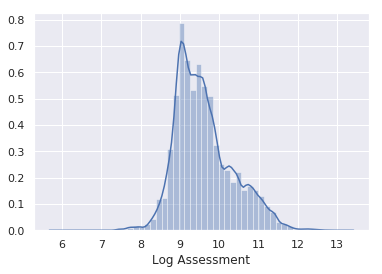

In [10]:
sns.distplot(df['Log Assessment'].dropna())

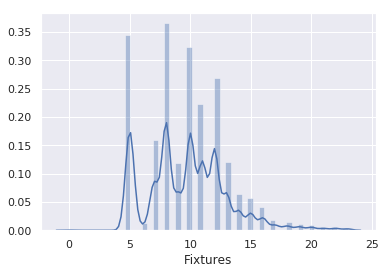

In [11]:
sns.distplot(df['Fixtures'].dropna())

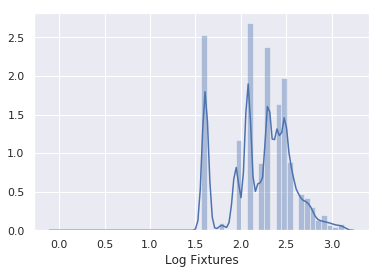

In [12]:
sns.distplot(df['Log Fixtures'].dropna())

In [13]:
df.nlargest(10, 'Land Area Acres')

,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds2,Building Condition,Building Condition2,Building Grade,...,Month,Quarter,Year,Log Assessment,Log Fixtures,Log SqFt,Log PPS,Log Land,Log NbhdPPS,Log NbhdRatio
80374,RES,"$34,425","$31,175","$65,600",2019.0,2.0,3.0,Average,Average,C,...,10,4,2017,10.347372,2.302585,7.877397,5.358295,2.076938,4.718547,-2.918687
201384,RES,"$4,025","$24,575","$28,600",2019.0,1.0,NaN,Very Poor,NaN,D,...,8,3,2015,10.109485,1.609438,6.740519,4.937921,2.046402,5.022809,-1.975407
125549,RES,"$12,025","$36,925","$48,950",2019.0,1.0,NaN,Fair,NaN,D,...,9,3,2017,10.516644,1.609438,7.069874,5.237265,2.030776,4.974172,-2.198142
104137,RES,"$37,000","$43,050","$80,050",2019.0,1.0,NaN,Average,NaN,C,...,12,4,2016,10.670118,1.945910,7.344073,5.421616,2.029463,4.768629,-2.816275
104114,RES,"$33,125","$41,250","$74,375",2019.0,1.0,NaN,Fair,NaN,C,...,5,2,2017,10.627406,1.945910,7.832014,4.821944,1.981001,4.768629,-2.816275
144627,RES,"$105,425","$44,200","$149,625",2019.0,3.0,NaN,Average,NaN,B,...,3,1,2015,10.696480,2.397895,8.221210,5.085140,1.951608,4.947243,-2.580509
229502,RES,"$25,250","$63,000","$88,250",2019.0,2.0,NaN,Average,NaN,E,...,7,3,2017,11.050890,2.302585,7.731931,4.994423,1.948763,4.718547,-2.918687
190678,RES,"$253,125","$210,500","$463,625",2019.0,6.0,NaN,Average,NaN,X,...,11,4,2016,12.257241,3.135494,8.976641,5.426656,1.919859,5.402266,-2.047633
146606,RES,"$152,875","$140,825","$293,700",2019.0,4.0,NaN,Average,NaN,X,...,6,2,2015,11.855273,2.772589,8.797700,5.260757,1.912501,5.213084,-2.205598
128812,RES,"$302,600","$525,300","$827,900",2019.0,7.0,1.0,Fair,Fair,X,...,1,1,2015,13.171725,3.135494,8.966229,5.980684,1.902108,5.721254,-1.992677


In [14]:
np.std(df.PPS)

82.58664760002395

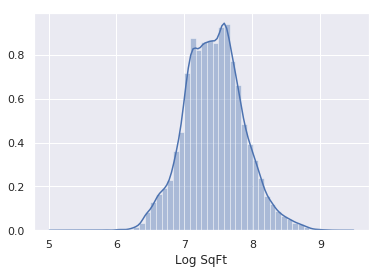

In [15]:
sns.distplot(df['Log SqFt'].dropna())

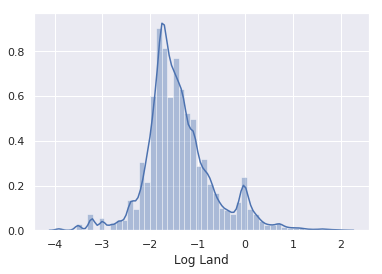

In [16]:
sns.distplot(df['Log Land'].dropna())

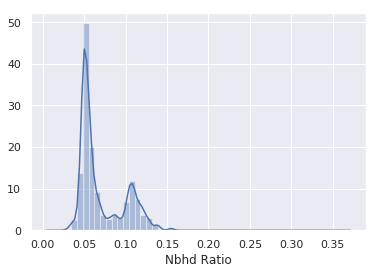

In [17]:
sns.distplot(df['Nbhd Ratio'].dropna())
df=df[df['Nbhd Ratio'] <= 0.3]

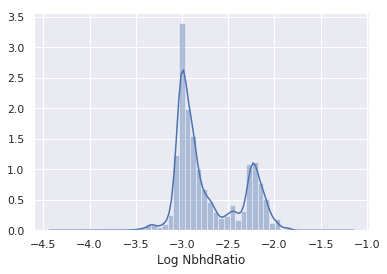

In [18]:
sns.distplot(df['Log NbhdRatio'].dropna())

In [19]:
meanpps.nlargest(15,'NeighborhoodPPS')
#NeighborhoodPPS distributes pretty unevenly. A transform might help.

,NeighborhoodPPS
Neighborhood,
3211,778.711485
6264,752.879821
6442,536.781227
6375,523.752618
4267,506.597339
4098,495.971656
6444,463.819647
4264,449.984079
4262,448.504625


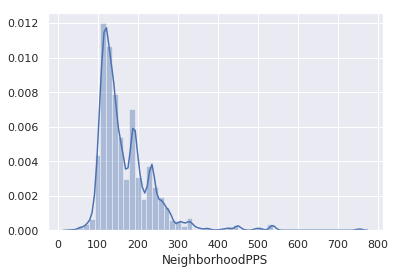

In [20]:
sns.distplot(df['NeighborhoodPPS'].dropna())
df=df[df.NeighborhoodPPS<=2000]

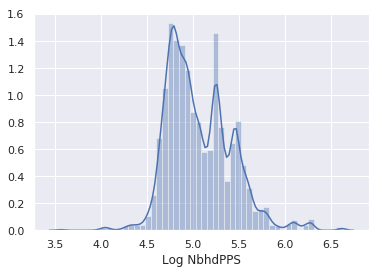

In [21]:
sns.distplot(df['Log NbhdPPS'].dropna())

## Now to the Machine Learning:

First I'll run a dummy regressor, which just guesses the mean. Then I'll attempt a few different models with increasing accuracy.

In [22]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import median_absolute_error as MAE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error as MSLE

In [23]:
df2 = df[['Log NbhdRatio','Building Condition','Log SqFt','Log Fixtures','Building Type Custom','Building Grade','Exterior Wall','Year','Log NbhdPPS', 'PPS', 'Quarter', 'Log Assessment', 'Year Built', 'Zone']]
df2=df2.dropna()

In [ ]:
#dtreeviz doesn't work with features whose names have spaces.
df2.columns = ['Log-NbhdRatio', 'Building-Condition', 'Log-SqFt', 'Log-Fixtures',
       'Building-Type-Custom', 'Building-Grade', 'Exterior-Wall', 'Year',
       'Log-NbhdPPS', 'PPS', 'Quarter', 'Log-Assessment', 'Year-Built', 'Zone']

In [ ]:
from sklearn.model_selection import train_test_split
X= pd.get_dummies(df2[['Zone','Log-NbhdPPS','Building-Grade','Log-SqFt','Year', 'Log-Assessment','Log-Fixtures','Exterior-Wall', 'Year-Built']])
y=df2['PPS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.28, random_state=42)

In [ ]:
print(df.shape)
print(df2.shape)

(53967, 80)
(53888, 14)


In [ ]:
from sklearn.dummy import DummyRegressor as DR
model = DR(strategy='median')
dr=model.fit(X_train, y_train)
y_pred= dr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_yyytest))**0.5)
print(MSE(y_pred, y_test)**0.5)

84.44576817036904


In [ ]:
from sklearn.tree import DecisionTreeRegressor as DTR
model = DTR()
dtr=model.fit(X_train, y_train)
y_pred= dtr.predict(X_test)
print(MSE(y_pred, y_test)**0.5)
#Out of the box, this is a decent score. 

42.91040612716659


In [ ]:
from sklearn.ensemble import RandomForestRegressor as RFR
model = RFR(random_state=42)
rfr=model.fit(X_train,y_train)
y_pred=rfr.predict(X_test)
# print(MSE(np.exp(y_pred), np.exp(y_test))**0.5)
print(MSE(y_pred, y_test)**0.5)

/home/drew/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


33.33387189668943


In [ ]:
from xgboost import XGBRegressor as XGBR
#Best model parameters from GridSearchCV
model = XGBR(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.08, max_delta_step=0,
       max_depth=6, min_child_weight=1.5, missing=None, n_estimators=600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

xgbr=model.fit(X_train,y_train)
y_predxg=xgbr.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predxg)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predxg)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predxg)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predxg)))
print('Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predxg),np.abs(y_test))))

[11:35:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/drew/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 30.671369826157118
Median Absolute Error: 11.80884958427643
Mean Absolute Error: 19.170595756626707
Coefficient of Determination: 0.8612523267334568
Mean Squared Logarithmic Error: 0.04065469282805076


<Figure size 648x648 with 0 Axes>

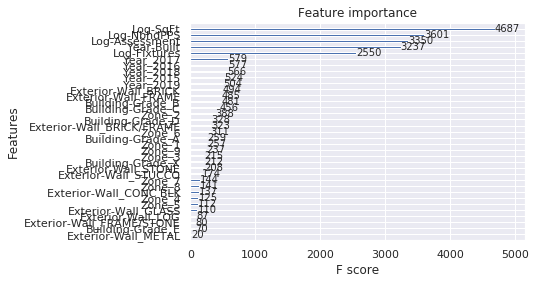

In [ ]:
import xgboost as xgb
plt.figure(figsize=(9,9))
xgb.plot_importance(model)

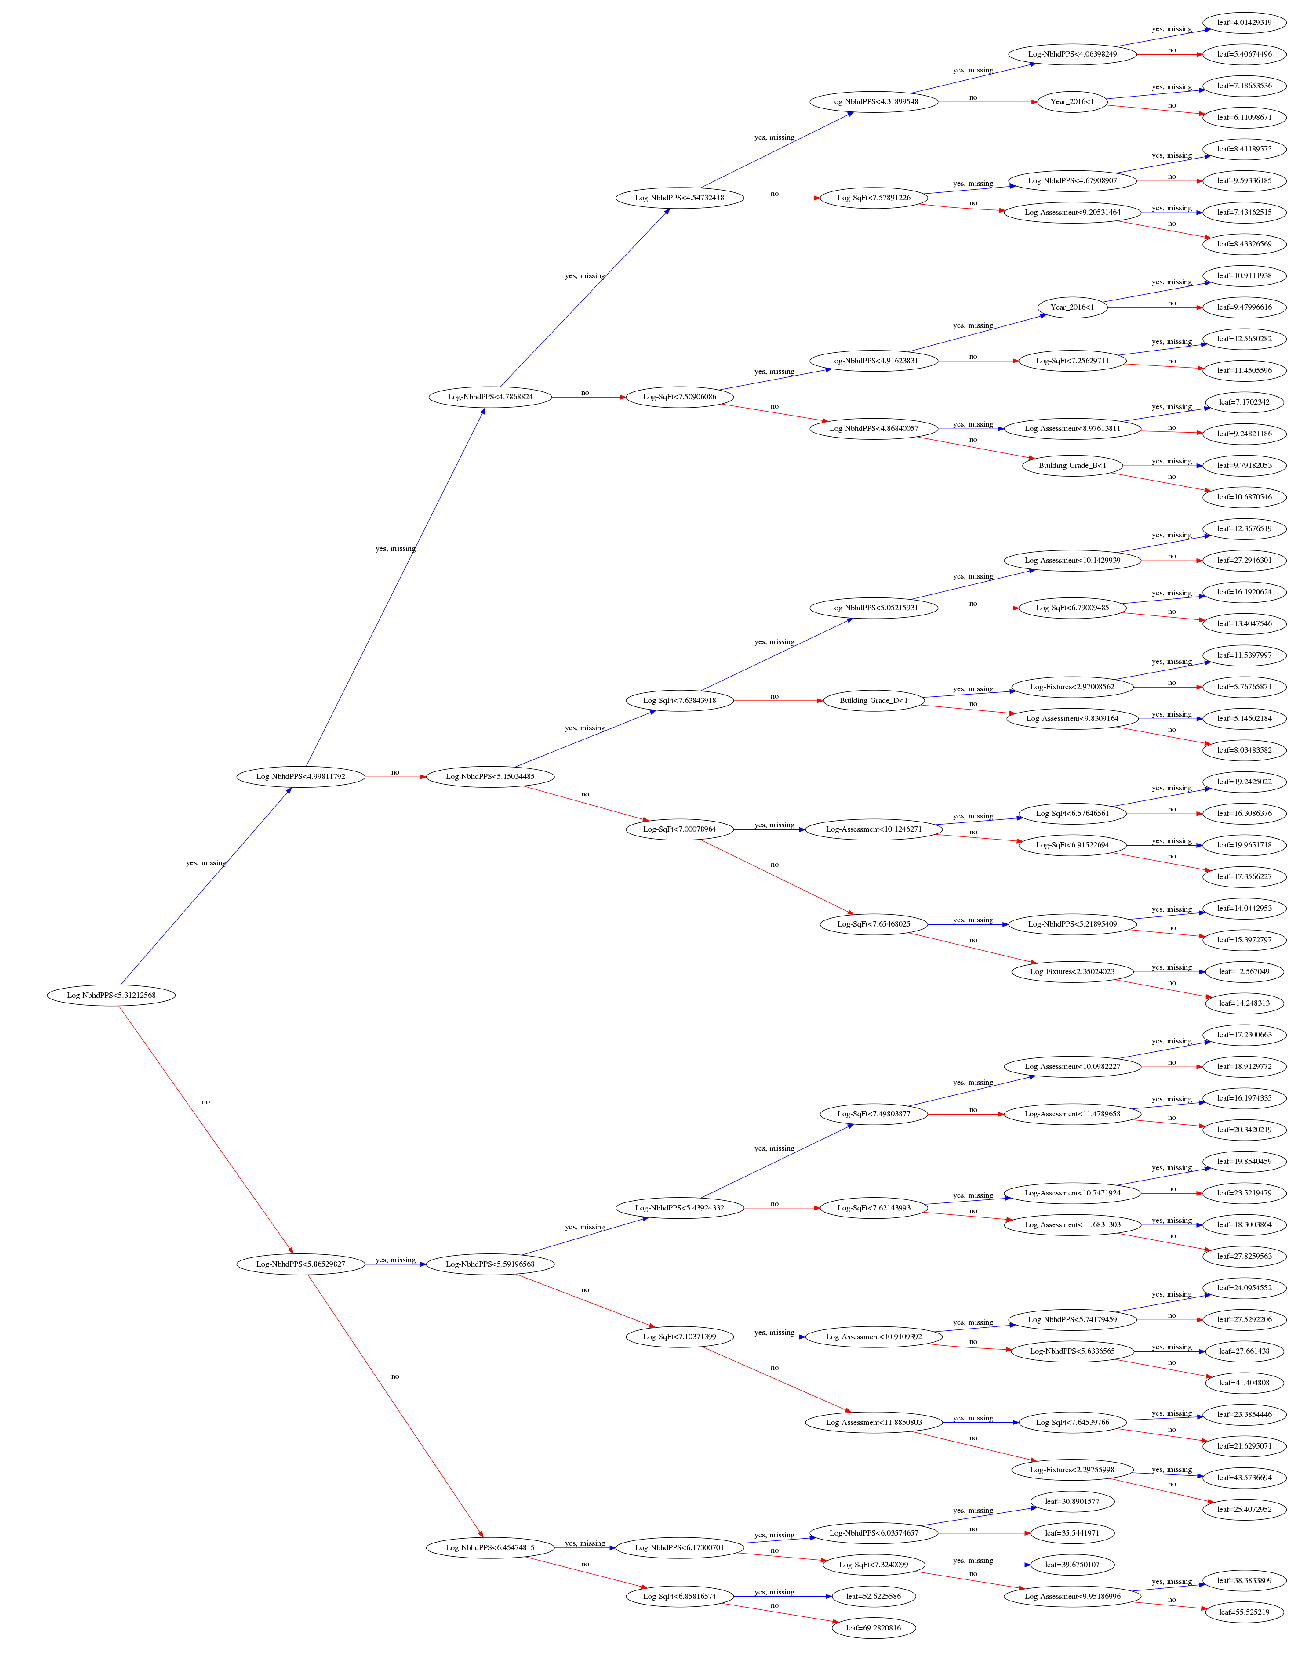

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
xgb.plot_tree(model, ax=ax, rankdir='LR')
plt.show()

In [ ]:
# from sklearn.model_selection import GridSearchCV
# params={'learning_rate':[.07,.08,.09]}
# rfgrid = GridSearchCV(estimator = xgbr,param_grid=params, cv = 5, verbose=2, n_jobs = -1)
# rfgrid.fit(X, y)

In [ ]:
# print(MSE(y_test, rfgrid.best_estimator_.predict(X_test))**0.5) 
# print(MAE(y_test, rfgrid.best_estimator_.predict(X_test)))
# print(rfgrid.best_estimator_)

### Now testing Microsoft's LightGBM

In [ ]:
import lightgbm as lgb
dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_test,y_test)
evals_result={}
params = {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 500, 'num_leaves': 350}
gbm = lgb.train(params=params,
                train_set= dtrain,
                valid_sets=[dtrain, dvalid],
                num_boost_round=100,
                evals_result=evals_result,
                verbose_eval=10)
y_predgbm=gbm.predict(X_test)
print('RMSE: {}'.format(MSE(y_test,y_predgbm)**0.5))
print('Median Absolute Error: {}'.format(MAE(y_test,y_predgbm)))
print('Mean Absolute Error: {}'.format(mean_absolute_error(y_test, y_predgbm)))
print('Coefficient of Determination: {}'.format(r2_score(y_test, y_predgbm)))
print('Mean Squared Logarithmic Error: {}'.format(MSLE(np.abs(y_predgbm),np.abs(y_test))))

/home/drew/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSE: 30.34622491973916
Median Absolute Error: 11.438461210985281
Mean Absolute Error: 18.909007023581204
Coefficient of Determination: 0.8641784418168268
Mean Squared Logarithmic Error: 0.03908501154658836


In [ ]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()
evals_result={}
param_grid = {
    'learning_rate': [0.18,0.21],
    'n_estimators': [500],
    'min_child_weight':[30,50],
    'max_depth': [5],
    'num_leaves': [350]
    }
params={}
gbm = GridSearchCV(estimator, param_grid, cv=5, scoring ='neg_mean_squared_error')
gbm.fit(X_train, y_train)
y_predlgb= gbm.predict(X_test)
print('Best parameters found by grid search are:', gbm.best_params_)
print(gbm.best_score_)
print(MSE(y_test,y_predlgb)**0.5)
print(MAE(y_test,y_predlgb))
print(mean_absolute_error(y_test, y_predlgb))
print(r2_score(y_test, y_predlgb))

Best parameters found by grid search are: {'learning_rate': 0.18, 'max_depth': 5, 'min_child_weight': 30, 'n_estimators': 500, 'num_leaves': 350}
-928.71015434777
30.34622491973916
11.438461210985281
18.909007023581204
0.8641784418168268


In [ ]:
gbm.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.18, max_depth=5,
       min_child_samples=20, min_child_weight=30, min_split_gain=0.0,
       n_estimators=500, n_jobs=-1, num_leaves=350, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Examining residual errors

In [ ]:
copiedxg= X_test.copy()
copiedxg['Actual']= y_test
copiedxg['Predicted']= y_predxg
copiedxg['Residual'] = np.absolute(copiedxg['Actual'] - copiedxg['Predicted'])

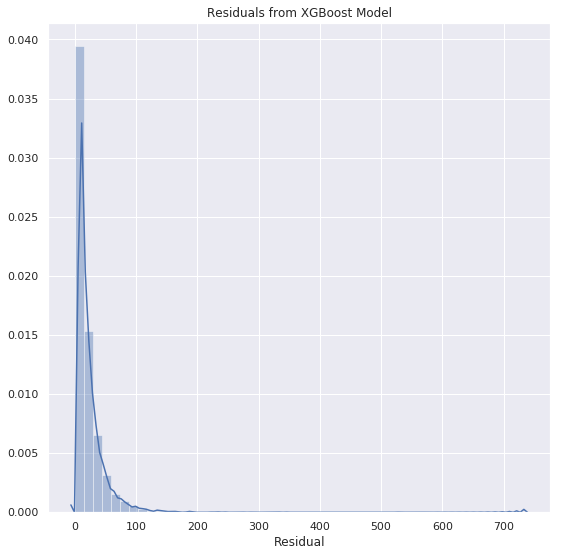

In [ ]:
plt.figure(figsize=(9,9))
plt.title('Residuals from XGBoost Model')
sns.distplot(copiedxg.Residual.dropna())

In [ ]:
#The pattern in my biggest flubs is, there's a big difference between the NeighborhoodPPS and the actual PPS
#However, adding NeighborhoodPPS to the model significantly increases performance.
#So how can I tune it to accept NeighborhoodPPS while minimizing this error?
copiedxg.nlargest(15,'Residual')[['Log-NbhdPPS', 'Actual', 'Predicted', 'Residual']]

,Log-NbhdPPS,Actual,Predicted,Residual
106716,5.341130,1078.993056,346.619263,732.373793
110153,5.478194,723.981900,196.152664,527.829236
28878,4.897253,490.485252,116.286171,374.199081
45773,5.048100,506.072874,159.238251,346.834624
261255,6.285591,1091.422702,758.048706,333.373996
45775,5.048100,416.666667,127.123756,289.542910
91666,5.248813,729.361702,455.787628,273.574074
279628,6.623906,1068.376068,802.868835,265.507233
261294,5.115802,421.052632,175.281235,245.771397
85995,5.278474,500.000000,257.349976,242.650024


In [ ]:
copiedxg.nlargest(15, 'Residual')[['Actual','Predicted','Residual', 'Log-NbhdPPS']]

,Actual,Predicted,Residual,Log-NbhdPPS
106716,1078.993056,346.619263,732.373793,5.341130
110153,723.981900,196.152664,527.829236,5.478194
28878,490.485252,116.286171,374.199081,4.897253
45773,506.072874,159.238251,346.834624,5.048100
261255,1091.422702,758.048706,333.373996,6.285591
45775,416.666667,127.123756,289.542910,5.048100
91666,729.361702,455.787628,273.574074,5.248813
279628,1068.376068,802.868835,265.507233,6.623906
261294,421.052632,175.281235,245.771397,5.115802
85995,500.000000,257.349976,242.650024,5.278474


In [ ]:
copiedlgb= X_test.copy()
copiedlgb['Actual']= y_test
copiedlgb['Predicted']= y_predgbm
copiedlgb['Residual'] = np.absolute(copiedlgb['Actual'] - copiedlgb['Predicted'])

copiedlgb.nlargest(15, 'Residual')

,Log-NbhdPPS,Log-SqFt,Log-Assessment,Log-Fixtures,Year-Built,Zone_1,Zone_2,Zone_3,Zone_4,Zone_5,...,Exterior-Wall_FRAME/STONE,Exterior-Wall_GLASS,Exterior-Wall_LOG,Exterior-Wall_METAL,Exterior-Wall_PRECAST CONC,Exterior-Wall_STONE,Exterior-Wall_STUCCO,Actual,Predicted,Residual
106716,5.341130,6.356108,10.203592,1.791759,2004.0,0,1,0,0,0,...,0,0,0,0,0,0,0,1078.993056,370.992365,708.000691
110153,5.478194,8.106213,9.798127,2.639057,1976.0,0,1,0,0,0,...,0,0,0,0,0,0,0,723.981900,223.255526,500.726375
28878,4.897253,6.957497,8.955448,1.609438,1935.0,0,0,0,0,0,...,0,0,0,0,0,0,0,490.485252,129.701709,360.783543
45773,5.048100,6.895683,9.339173,1.609438,1956.0,0,0,0,1,0,...,0,0,0,0,0,0,0,506.072874,165.015395,341.057479
228237,6.261019,7.824046,9.838949,2.484907,1890.0,0,0,0,0,0,...,0,0,0,0,0,0,0,292.000000,630.967819,338.967819
279628,6.623906,6.959399,10.349775,2.079442,2018.0,0,0,0,0,0,...,0,1,0,0,0,0,0,1068.376068,772.022410,296.353658
45775,5.048100,7.090077,9.339173,1.609438,1956.0,0,0,0,1,0,...,0,0,0,0,0,0,0,416.666667,136.016064,280.650602
261294,5.115802,7.103322,9.132379,2.302585,2014.0,0,0,0,0,0,...,0,0,0,0,0,0,0,421.052632,172.860526,248.192106
116250,5.648999,7.003065,11.225243,1.609438,1972.0,0,1,0,0,0,...,0,0,0,0,0,0,0,181.818182,429.243226,247.425044
95765,6.084246,7.138867,10.165852,2.197225,1986.0,0,0,0,0,0,...,0,0,0,0,0,0,0,218.253968,457.455308,239.201340


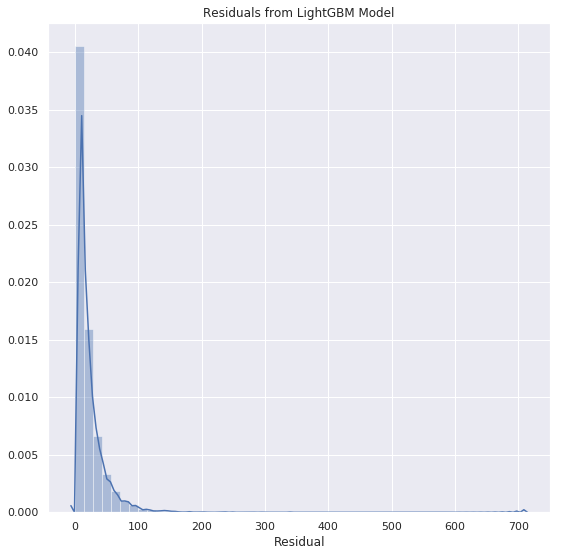

In [ ]:
plt.figure(figsize=(9,9))
plt.title('Residuals from LightGBM Model')
sns.distplot(copiedlgb.Residual.dropna())

## Interpretting the Model

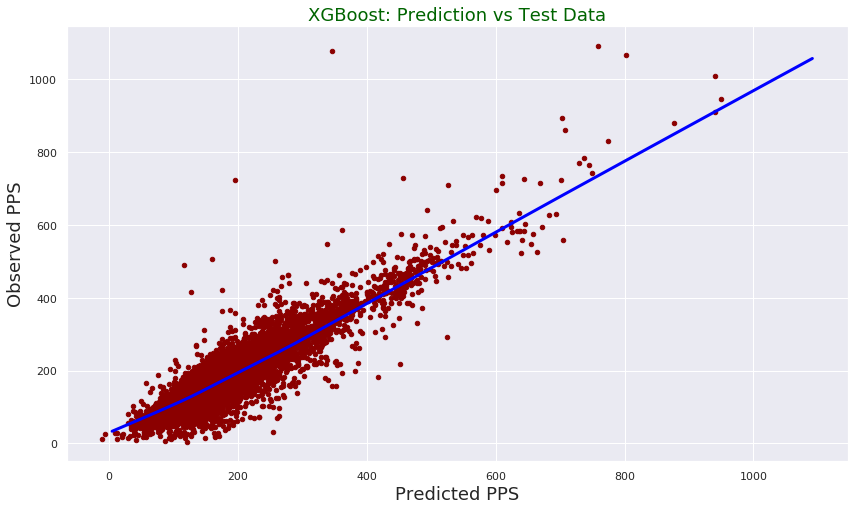

In [ ]:
import statsmodels as sm
lowess = sm.nonparametric.smoothers_lowess.lowess
z = lowess(y_predxg, y_test)
test = pd.DataFrame({"prediction": copiedxg['Predicted'], "observed": copiedxg['Actual']})
test.plot(figsize = [14,8],
          x ="prediction", y = "observed", kind = "scatter", color = 'darkred')
plt.title("XGBoost: Prediction vs Test Data", fontsize = 18, color = "darkgreen")
plt.xlabel("Predicted PPS", fontsize = 18) 
plt.ylabel("Observed PPS", fontsize = 18)
plt.plot(z[:,0], z[:,1], color = "blue", lw= 3)
plt.show()

Text(0.5, 0, 'Z: Neighborhood PPS')

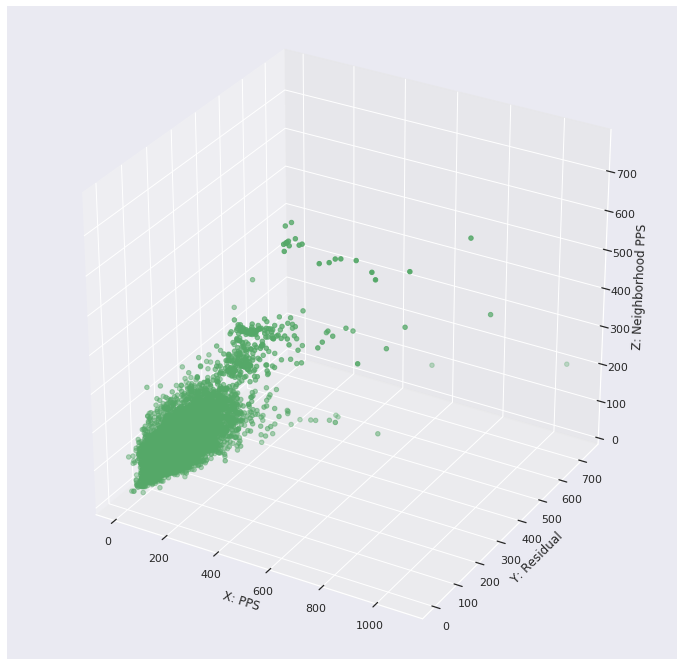

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

x =copiedxg['Actual']
y =copiedxg['Residual']
z =copiedxg['Log-NbhdPPS'].map(lambda x: np.exp(x))

ax.scatter(x, y, z, c='g', marker='o')
ax.set_xlabel('X: PPS')
ax.set_ylabel('Y: Residual')
ax.set_zlabel('Z: Neighborhood PPS')

#It looks like the biggest residuals are for houses where the actual PPS was very different from the average PPS in the neighborhood.
#To clarify: these observations are up (high Neighborhood PPS), to the left (low PPS), and back (high residual error)

Text(0, 0.5, 'Residual')

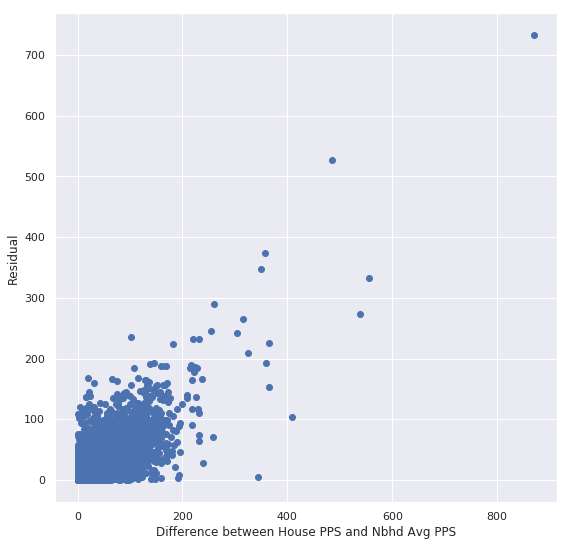

In [ ]:
diff = np.abs(copiedxg['Actual']-copiedxg['Log-NbhdPPS'].map(lambda x: np.exp(x)))
plt.figure(figsize=(9,9))
plt.scatter(diff,copiedxg['Residual'])
plt.xlabel('Difference between House PPS and Nbhd Avg PPS')
plt.ylabel('Residual')
#So the residual is linearly correlated with how different the house's PPS is from the average PPS in its neighborhood.
#However, NeighborhoodPPS is an important feature in the ML model and performance suffers without it
#To me, this means the NeighborhoodPPS is a good start for a metric, but can be improved (with historical sales data)
#In my next iteration of the model, I'll put in more info about sales in each neighborhood.

## Model Interpretation with SHAP
Features in red pushed the prediction higher, features in blue pushed it lower. 
SHAP visualizes with D3 and GitHub doesn't display JavaScript so I won't add any SHAP plots past these 2 for now.

In [ ]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test.iloc[199,:])
#Visualize the feature effects for the 200th prediction (chosen as a random example)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[199,:])
#Features in red pushed the prediction higher, blue features pushed it lower.

In [ ]:
# #I run into this memoryerror issue with SHAP. Shap may require a seperate notebook because it's very computationally-intensive.
# shap_values = explainer.shap_values(X_test)
# shap.force_plot(explainer.expected_value, shap_values, X_test)